In [1]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np

from my_functions import *


### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [2]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio\SRC
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [3]:
plt.close("all")  # close all figure windows

## Initialization

### Xdf file selection and loading (REARM data)

In [4]:
# Define the xdf file of interest
xdf_input_filename="001_MolLud_20201112_1_c.xdf"
#xdf_input_filename="020_DesMar_20211129_1_c.xdf"

xdf_input_filepath=os.path.normpath("DAT/INPUT/"+xdf_input_filename)

In [5]:
def list_stream_names(stream_list:list):
    """
    Lists the name of the streams founded by pyxdf's multistream importer.

    Parameters:
    ----------
        -stream_list (list): List of streams founded.

    Returns:
    --------
        - stream_names (list): list of names of the founded streams
    """
    stream_names=[]

    for stream in stream_list:
        stream_name=stream["info"]["name"][0]
        stream_names.append(stream_name)
    
    return stream_names

In [6]:
def retrieve_stream_data_from_xdf(xdf_input_filepath:str,stream_type:str,stream_name:str=None):
    """
    Retrieves data and recording setup information from a selected stream of an xdf file and return them tidied for ReArm needs.

    Returns the data as a nested dictionary.
    
    Note: Currently handeled stream types: "EEG", "Mocap", "Markers".

    Parameters:
    -----------
        - xdf_input_filepath (str): Filepath towards xdf file to analyze
        - stream_type (str) : Type of the stream to look for
        - stream_name (str): (optional) Name of the stream if multiple are found.

    Returns:
    -----------
        - stream_result_data (dict): 
            - "data" (dict): 
                - "time_series" : stream_data_samples (np.ndarray) - 2D array of raw samples (each column contains data from a channel)
                - "timestamps": stream_data_timestamps (np.ndarray) - 1D array of raw timestamps (associated to each sample)
            - "infos" (dict):
                - "sample_rate" (dict):
                    - "nominal_srate" : nominal_srate (float) - nominal sampling rate of the recording
                    - "effective_srate" : effective_srate (float) - effective sampling rate of the recording 
                - "channels" (dict):
                    - "names" : channel_names (list) - list of channel names
                    - "units" : channel_units (list) - list of channel data units
    
                - "recording_time_limits" (dict): 
                    - "recording_start" : recording_start (float) - first_timestamp (units?)
                    - "recording_end" : recording_end (float) - last_timestamp (units?)

    """
    
    if stream_name is not None:
        stream_list, fileheader = pyxdf.load_xdf(xdf_input_filepath, select_streams=[{'type': stream_type,'name': stream_name}])
    else :
        stream_list, fileheader = pyxdf.load_xdf(xdf_input_filepath, select_streams=[{'type': stream_type}])

    if len(stream_list) > 1:
        stream_names = list_stream_names(stream_list)
        raise Exception(f"More than one stream nammed '{stream_type}' was found. Stream names : {stream_names} \n Try specifying the stream name when calling the function. ")

    else:
        stream_data = stream_list[0]
        #print(EEG_data)

    #get stream data
    stream_data_timestamps = stream_data["time_stamps"]
    stream_data_samples = stream_data["time_series"]

    #get channel names and units
    channel_names = []
    channel_units = []
    if stream_type == "EEG":
        for i in range(stream_data_samples.shape[-1]):
            channel_i_name = stream_data["info"]["desc"][0]["channel"][i]["name"][0]
            channel_i_unit = stream_data["info"]["desc"][0]["channel"][i]["unit"][0]
            channel_names.append(channel_i_name)
            channel_units.append(channel_i_unit)
    elif stream_type == "MoCap":
        for i in range(stream_data_samples.shape[-1]):
            channel_i_name = stream_data["info"]["desc"][0]["channels"][0]["channel"][i]["label"][0]
            channel_i_unit = stream_data["info"]["desc"][0]["channels"][0]["channel"][i]["unit"][0]
            channel_names.append(channel_i_name)
            channel_units.append(channel_i_unit)
    elif stream_type == "Markers":
            channel_names.append("Maker_labels")
            channel_units.append(None)
    else:
        raise Exception(f"stream type {stream_type} not handeled yet")


    #get sample rates
    nominal_srate = float(stream_data["info"]["nominal_srate"][0])
    effective_srate = float(stream_data["info"]["effective_srate"])

    #get recording landmarks
    recording_start = float(stream_data["footer"]["info"]["first_timestamp"][0])
    recording_end = float(stream_data["footer"]["info"]["last_timestamp"][0])

    #store data in dictionaries
    data_dict = {"time_series":stream_data_samples,"timestamps":stream_data_timestamps}

    info_dict = {"sample_rate":{ "nominal":nominal_srate,"effective":effective_srate},
                 "recording_time_limits":{"start":recording_start,"end":recording_end},
                 "channels":{"names":channel_names,"units":channel_units}}

    stream_result_data={"data":data_dict,"infos":info_dict}
    return stream_result_data

In [7]:
test=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="EEG")
print(test["infos"]["channels"]["names"])
print(test["infos"]["channels"]["units"])

['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8']
['microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts']


In [8]:
retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="MoCap",stream_name="Mouse")

{'data': {'time_series': array([[634., 810.,   1.],
         [632., 810.,   1.],
         [631., 811.,   1.],
         ...,
         [371., 679.,   1.],
         [362., 666.,   1.],
         [  0.,   0.,   0.]], dtype=float32),
  'timestamps': array([683474.98482845, 683474.99548071, 683475.00613298, ...,
         683727.15089722, 683727.16154399, 683727.17219077])},
 'infos': {'sample_rate': {'nominal': 100.0, 'effective': 93.92194728374322},
  'recording_time_limits': {'start': 683474.9270993, 'end': 683727.1659653},
  'channels': {'names': ['mouseX', 'mouseY', 'mouseInTarget'],
   'units': ['pixels', 'pixels', 'boolean']}}}

In [9]:
retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="Markers",stream_name="MouseToNIC")

{'data': {'time_series': array([[111],
         [100],
         [111],
         [100],
         [111],
         [100],
         [111],
         [100],
         [111],
         [100],
         [111],
         [100]]),
  'timestamps': array([683474.4032842 , 683494.40532136, 683514.40691942, 683534.40919337,
         683554.40970723, 683574.41099179, 683627.16012687, 683647.16022163,
         683667.16187809, 683687.16441704, 683707.165428  , 683727.16588116])},
 'infos': {'sample_rate': {'nominal': 0.0, 'effective': 0.0},
  'recording_time_limits': {'start': 683474.4032944, 'end': 683727.1658919},
  'channels': {'names': ['Maker_labels'], 'units': [None]}}}

In [10]:
def create_marker_times_labels_array2(marker_time_stamps:np.ndarray=None,marker_labels:np.ndarray=None,xdf_input_filepath:str=None):
    """
    Create an array combining the markers labels and their timestamps.
        If xdf file specified, timestamps are retrieved from the file and processed to start relative to recording start, not to unix epoch anymore.
        If marker_time_stamps and marker_labels, the arrays are stacked and returned as defined.

    Parameters
    ----------
        marker_time_stamps (np.ndarray): 1D array containing the marker timestamps.
        marker_labels (np.ndarray): 1D array containing the markers labels.
        xdf_input_filepath (str): Filepath of the EEG recordings as xdf file.
        
    Returns
    -------
        markers_times_labels (np.ndarray): 2D array containing the markers's timestamps alongside their labels in this order: [marker_timestamps,marker_labels].
    """
    all_args = [xdf_input_filepath,marker_time_stamps,marker_labels]
    is_all_none = all(element is None for element in all_args)
    
    if is_all_none:
        raise Exception("No arguments specified.")
    elif xdf_input_filepath:
        #Retrieve directly from xdf file markers timestamps relative to recording start and their labels
        mouse_markers_data = retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,
                                      stream_type="Markers",stream_name="MouseToNIC")
        mouse_markers_labels = mouse_markers_data["data"]["time_series"]
        mouse_markers_times = mouse_markers_data["data"]["timestamps"]-mouse_markers_data["data"]["timestamps"][0]
        markers_times_labels=np.column_stack((mouse_markers_times,mouse_markers_labels))

    else:
        #stack given arrays to create the marker_times_labels array
        markers_times_labels=np.column_stack((marker_time_stamps,marker_labels))
    return markers_times_labels

In [11]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

In [12]:
# compute the tangential speed

def compute_tangential_speed(coordinates:np.ndarray,sample_rate:float):
    """
    Computes the tangential speed from xy coordinates.
    
    Parameters
    ----------
        coordinates (np.ndarray): 2D array containing X and Y mouse positions in first and second columns respectively
        sample_rate (float) : sampling rate of the coordinates

    Returns
    ----------
        result_data (np.ndarray): 2D array containing X and Y mouse position at each time and the corresponding instantaneous tangential speeds
            col 1: x positions
            col 2: y positions
            col 3: tangential speed
    """
    #sampling period
    Ts=1/sample_rate

    x_coordinates=coordinates[:,0]
    y_coordinates=coordinates[:,1]

    #position difference between two consecutive samples
    dx=np.diff(x_coordinates,prepend=0)
    dy=np.diff(y_coordinates,prepend=0)

    #compute the instantaneous speeds in each direction
    vx=dx/Ts
    vy=dy/Ts

    #compute the total tangential speed
    vt=np.sqrt(vx**2+vy**2)

    return vt

In [13]:
def show_markers2(plot_type, markers_times_array: np.ndarray):
    """
    Function that displays event markers as vertical lines on a graph (plt or axis). 
    Inherits of the plot_type object to add marker to figure.

    Parameters
    ----------
    plot_type (object): Parent graph object (plt, or axis)
    markers_times_array (np.ndarray): 2D array of markers where column 1 is timestamps and column 2 marker labels in this order.

    Returns
    ----------
        markers (list): List of axvline methods with specific arguments given
    """
    unique_labels=set()
    markers=[]

    # iterate over an array of markers
    for marker in markers_times_array:
        timestamp,label=marker
        label=str(int(label))
        # use different color for marker 111 and 100
        if label == "111":
            color = "b"
        elif label == "100":
            color = "r"
        else:
            color = "green"
            
        #each marker type corresponds to a unique label
        if label in unique_labels:
            label= None
        else:
            unique_labels.add(label)

        marker_axvline_obj=plot_type.axvline(x=timestamp,color=color,label=label)
        markers.append(marker_axvline_obj)

    return markers

In [14]:
mouse_marker_data=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="Markers",stream_name="MouseToNIC")
mouse_marker_times=mouse_marker_data["data"]["timestamps"]-mouse_marker_data["data"]["timestamps"][0]
mouse_marker_labels=mouse_marker_data["data"]["time_series"]

mouse_marker_times_labels = create_marker_times_labels_array(marker_time_stamps=mouse_marker_times,marker_labels=mouse_marker_labels.astype(str))
mouse_marker_times_labels2 = create_marker_times_labels_array2(xdf_input_filepath=xdf_input_filepath)


In [15]:
mouse_mocap_data=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="MoCap",stream_name="Mouse")

mouse_mocap_times=mouse_mocap_data["data"]["timestamps"]-mouse_mocap_data["data"]["timestamps"][0]
mouse_mocap_positions_xy=mouse_mocap_data["data"]["time_series"][:,0:2]
mouse_mocap_positions_units=np.unique(mouse_mocap_data["infos"]["channels"]["units"][0:2])[0]
mouse_mocap_sample_rate=mouse_mocap_data["infos"]["sample_rate"]["effective"]

mouse_mocap_speeds=compute_tangential_speed(coordinates=mouse_mocap_positions_xy,
                                            sample_rate=mouse_mocap_sample_rate)

mouse_mocap_speeds_threshold=0.05*np.max(mouse_mocap_speeds)
print(mouse_mocap_speeds_threshold)

print(f"vt_max= {np.max(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_min= {np.min(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_moy= {np.mean(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")

5007.724551040956
vt_max= 100154.4910208191 (pixels/s)
vt_min= 93.92194728374322 (pixels/s)
vt_moy= 1197.3543401322866 (pixels/s)


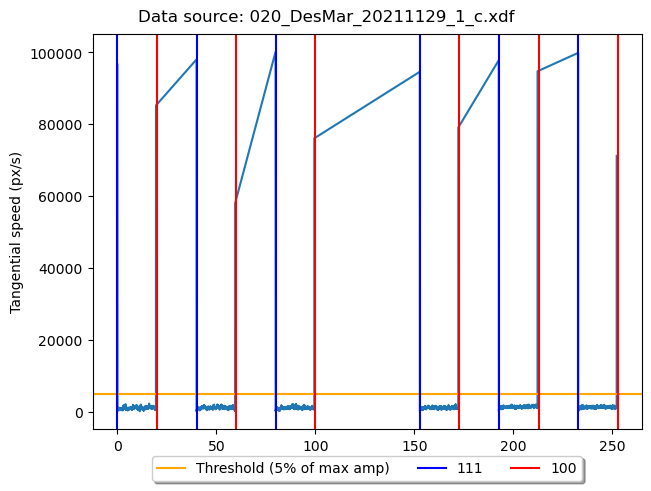

In [16]:
figure,axis=plt.subplots(layout="constrained")
figure.suptitle(f"Data source: {xdf_input_filename}")
axis.plot(mouse_mocap_times,mouse_mocap_speeds)
axis.axhline(mouse_mocap_speeds_threshold,label="Threshold (5% of max amp)",color="orange")
axis.set_ylabel("Tangential speed (px/s)")
axis.set_xlabel("time(s)")
show_markers2(plot_type=axis, markers_times_array=mouse_marker_times_labels2)
axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=3)

